# Proyeto Capstone - Analizando barrios de Nueva York para abrir un restaurante de comida peruana

## Introducción: Problema de Negocio

Nueva York, 'la ciudad que nunca duerme', es la ciudad mas grande de Estados unidos a lo largo de la historia, donde puedes encontrar personas con diversas culturas, por ser una de las principales ciudades con inmigrantes legales que viven aquí.

Debido a esta naturaleza multicultural en la ciudad de Nueva York, trajo consigo una diversa variedad de gastronomía; entre ellas, la gastronomía peruana. Perú siempre ha sido elogiado por su gastronomía en distintas partes del mundo. La mayoría de las personas una vez que prueban los platos típicos peruanos, no pueden esconder el gusto por ellos.

El objetivo de este proyecto es estudiar los barrios de Nueva York para determinar los mejores posibles lugares para abrir un restaurante de comida peruana. Este proyecto puede ser útil para dueños de negocios o emprendedores que estén planeando invertir en abrir un restaurante peruano en Nueva York. El principal objetivo de este proyecto es analizar de manera profunda la data apropiada con el fin de encontrar recomendaciones para los interesados.

#### Problema

Responderemos a las siguientes problemas:

1. ¿Cuales son los mejores lugares en Nueva York para la cocina Peruana?

2. ¿Qué áreas tienen el potencial del mercado de restaurantes peruanos?

3. ¿Cuál es el mejor lugar para invertir en aperturar un restaurante de comida Peruana?

## Data

Para este proyecto utilizaremos lo siguiente:

- La data de Nueva York que contiene los barrios y vecindarios con sus coordenada (longitud y latitud).
    - Fuente: https://cocl.us/new_york_dataset
    - Descripción: Esta data contiene la información requerida y la usaremos para explorar varios vecindarios de Nueva York.

- Restaurantes Peruanos de cada vecindarios de Nueva York.
    - Fuente: API FourSquare.
    - Descripción: Usando el API lograremos conseguir todos los sitios de cada vecindario. Podemos filtrar estos sitios por solo los restaurantes peruanos (Peruvian Restaurants)

- Coordenadas geográficas:
    - Con ayuda de la librería geocoder podremos obtener las latitudes y longitudes de los vecindarios de Nueva York, y así poder graficarlos en un mapa con ayuda de la librería folium.

-----

Importamos las librerías necesarias para nuestro proyecto

In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
#!pip install geocoder
!pip install geopy
import geocoder
import os
#!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim 
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Ahora definimos una función para obtener las coordenadas geográficas (latitud y longitud) usando geopy:

In [5]:
def geo_location(address):
    
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Definimos nuestras variables de CLIENT_ID, CLIENT_SECRET y VERSION para usarlas en el API de Foursquare

In [6]:
CLIENT_ID = 'UUH31W3ZKZ5WXA2K2DNQTUJV5NZVXDRX4UHKIJHEOYEZBTVQ' # your Foursquare ID
CLIENT_SECRET = 'HWTZUEAOMOEENE2J51OUFWTCWLTUQJFQ4WFGGC5D4UBJOCKA' # your Foursquare Secret
VERSION = '20210101' # Foursquare API version

Definimos una función para interactuar con el API de Foursquare y obetener los 100 mejores lugares en un radio de 1000 metros con respecto a una latitud y longitud. Esta función nos retornará el id del lugar (venue id), el nombre y la categoría.

In [7]:
def get_venues(lat,lng):
    
    #variables radius y limit
    radius=1000
    LIMIT=100

    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Definimos la función 'get_venue_details' para obtener otros datos como el número de likes, el rating y el número de tips por cada lugar. Esto se usará al momento de realizar el ranking.

In [8]:
def get_venue_details(venue_id):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Definimos la funcion 'get_ny_data' para obtener la data como los barrios y vecindarios con su longitud y latitud.

In [9]:
def get_ny_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # definir el nombre de las columnas del df
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # iniciar dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

Usamos la funcion 'get_ny_data' para obtener la data necesaria y la guardamos en el dataframe 'df'. Vemos la data y su tamaño

In [10]:
df = get_ny_data()

In [11]:
df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
df.shape

(306, 4)

##### Vemos que existen 306 vecindarios distintos en la ciudad de Nueva York.

Para visualizarlo mejor, crearemos un gráfico de barras con los distintos vecindarios

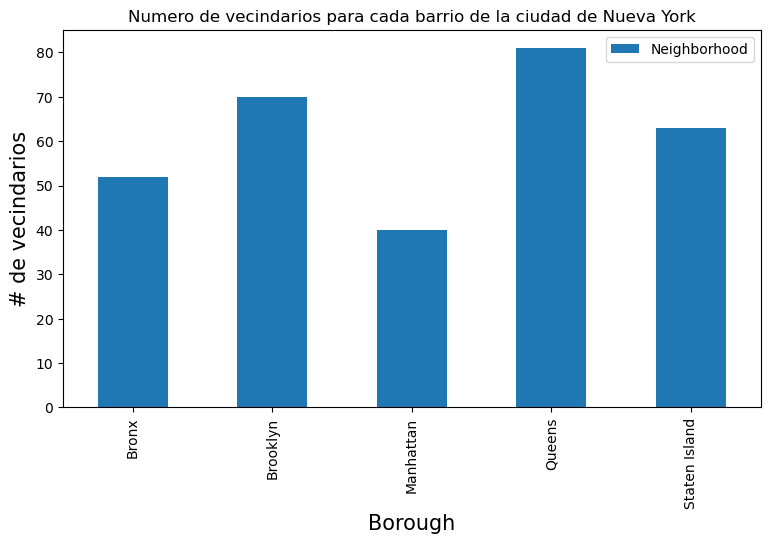

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Numero de vecindarios para cada barrio de la ciudad de Nueva York')
#On x-axis
plt.xlabel('Barrio', fontsize = 15)
#On y-axis
plt.ylabel('# de vecindarios', fontsize=15)
#giving a bar plot
df.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Del gráfico anterior, podemos identificar que <b> Queens </b> tiene el mayor número de vecindarios

Ahora identificaremos los restaurantes peruanos por cada vecindario

In [16]:
# Preparamos la lista de vecindarios que tienen restaurantes peruanos
column_names=['Borough', 'Neighborhood', 'ID','Name']
peruvian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in df.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    peruvian_resturants=venues[venues['Category']=='Peruvian Restaurant']   
    print('(',count,'/',len(df),')','Peruvian Resturants in '+Neighborhood+', '+Borough+':'+str(len(peruvian_resturants)))
    for resturant_detail in peruvian_resturants.values.tolist():
        id, name , category=resturant_detail
        peruvian_rest_ny = peruvian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Peruvian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Peruvian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Peruvian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Peruvian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Peruvian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Peruvian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Peruvian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Peruvian Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Peruvian Resturants in Norwood, Bronx:0
( 10 / 306 ) Peruvian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Peruvian Resturants in Baychester, Bronx:0
( 12 / 306 ) Peruvian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Peruvian Resturants in City Island, Bronx:0
( 14 / 306 ) Peruvian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Peruvian Resturants in University Heights, Bronx:0
( 16 / 306 ) Peruvian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Peruvian Resturants in Fordham, Bronx:0
( 18 / 306 ) Peruvian Resturants in Ea

( 138 / 306 ) Peruvian Resturants in Richmond Hill, Queens:1
( 139 / 306 ) Peruvian Resturants in Flushing, Queens:0
( 140 / 306 ) Peruvian Resturants in Long Island City, Queens:0
( 141 / 306 ) Peruvian Resturants in Sunnyside, Queens:2
( 142 / 306 ) Peruvian Resturants in East Elmhurst, Queens:1
( 143 / 306 ) Peruvian Resturants in Maspeth, Queens:1
( 144 / 306 ) Peruvian Resturants in Ridgewood, Queens:0
( 145 / 306 ) Peruvian Resturants in Glendale, Queens:0
( 146 / 306 ) Peruvian Resturants in Rego Park, Queens:3
( 147 / 306 ) Peruvian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Peruvian Resturants in Ozone Park, Queens:0
( 149 / 306 ) Peruvian Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Peruvian Resturants in College Point, Queens:0
( 151 / 306 ) Peruvian Resturants in Whitestone, Queens:0
( 152 / 306 ) Peruvian Resturants in Bayside, Queens:0
( 153 / 306 ) Peruvian Resturants in Auburndale, Queens:0
( 154 / 306 ) Peruvian Resturants in Little Neck, Queens:1
( 155 

( 271 / 306 ) Peruvian Resturants in Mount Hope, Bronx:0
( 272 / 306 ) Peruvian Resturants in Sutton Place, Manhattan:0
( 273 / 306 ) Peruvian Resturants in Hunters Point, Queens:0
( 274 / 306 ) Peruvian Resturants in Turtle Bay, Manhattan:0
( 275 / 306 ) Peruvian Resturants in Tudor City, Manhattan:0
( 276 / 306 ) Peruvian Resturants in Stuyvesant Town, Manhattan:0
( 277 / 306 ) Peruvian Resturants in Flatiron, Manhattan:0
( 278 / 306 ) Peruvian Resturants in Sunnyside Gardens, Queens:2
( 279 / 306 ) Peruvian Resturants in Blissville, Queens:1
( 280 / 306 ) Peruvian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Peruvian Resturants in Vinegar Hill, Brooklyn:1
( 282 / 306 ) Peruvian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Peruvian Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Peruvian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Peruvian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Peruvian Resturants in Willowbrook, Staten Island:0
( 287 / 3

Ahora que tenemos los restaurantes peruanos de NY en el df 'peruvian_rest_ny', lo analizaremos

In [18]:
peruvian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Melrose,4daf333f6a23d0da7e9abad9,La Granja Peruvian Restaurant
1,Bronx,Mott Haven,4bb28791715eef3b9f5e85bb,Pio Pio
2,Bronx,Mott Haven,4daf333f6a23d0da7e9abad9,La Granja Peruvian Restaurant
3,Bronx,Port Morris,4bb28791715eef3b9f5e85bb,Pio Pio
4,Brooklyn,Bath Beach,4e3c94bc483b04e17a8b15a6,La granja


In [19]:
peruvian_rest_ny.shape

(53, 4)

Nos damos cuenta que en NY existen 53 restaurantes en total.

Creamos un gráfico de barras para poder visualizar mejor la cantidad de restaurantes por cada barrio en NY.

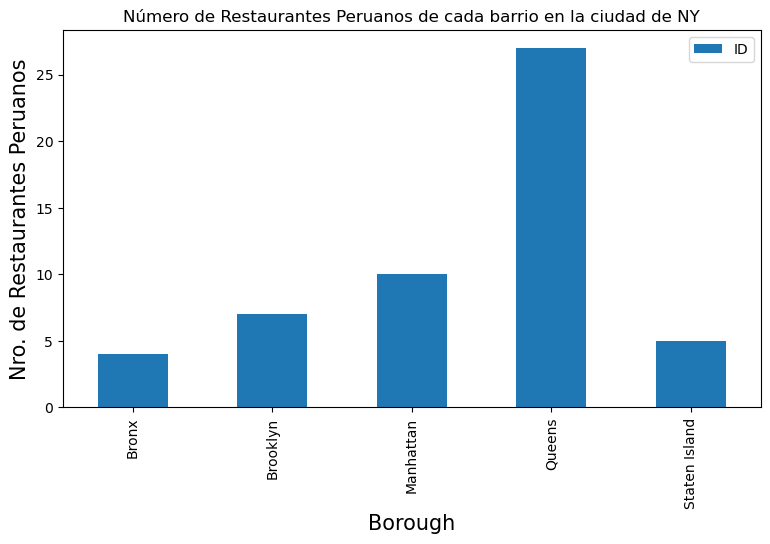

In [21]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Número de Restaurantes Peruanos de cada barrio en la ciudad de NY')
#On x-axis
plt.xlabel('Barrio', fontsize = 15)
#On y-axis
plt.ylabel('Nro. de Restaurantes Peruanos', fontsize=15)
#giving a bar plot
peruvian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

##### Con el gráfico anterior, podemos concluir que en Queens se encuentran la mayor cantidad de Restaurantes Peruanos

Ahora creamos un gráfico para verificar cuantos restaurantes peruanos existen por vecindario en la ciudad de NY

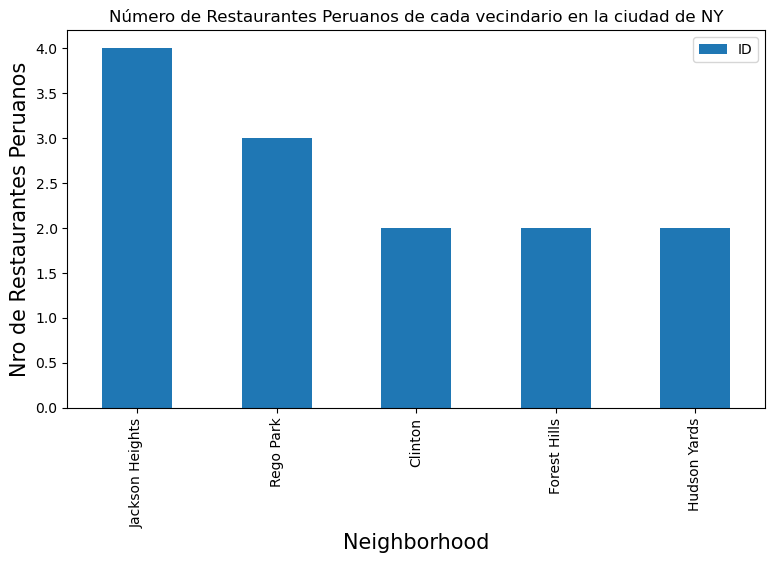

In [23]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Número de Restaurantes Peruanos de cada vecindario en la ciudad de NY')
#On x-axis
plt.xlabel('Vecindario', fontsize = 15)
#On y-axis
plt.ylabel('Nro de Restaurantes Peruanos', fontsize=15)
#giving a bar plot
peruvian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()

plt.show()

##### Podemos deducir del gráfico anterior que el vecindario <b> 'Jackson Heights' </b> es el que tiene mayor cantidad de restaurantes de comida peruana, con 4 restaurantes en total.

Ahora obtendremos el ranking (Likes, rating, tips) de cada restaurante para un análisis más profundo.

In [24]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
peruvian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in peruvian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # Asignaremos el valor de 0 para aquellos restaurantes que recién han abierto o su detalle no existe en la bd del API.
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(peruvian_rest_ny),')','processed')
    peruvian_rest_stats_ny = peruvian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                           Name  Likes  Rating  \
0  4daf333f6a23d0da7e9abad9  La Granja Peruvian Restaurant      5     7.2   

   Tips  
0     6  
( 1 / 53 ) processed
                         ID     Name  Likes  Rating  Tips
0  4bb28791715eef3b9f5e85bb  Pio Pio     67     8.6    23
( 2 / 53 ) processed
                         ID                           Name  Likes  Rating  \
0  4daf333f6a23d0da7e9abad9  La Granja Peruvian Restaurant      5     7.2   

   Tips  
0     6  
( 3 / 53 ) processed
                         ID     Name  Likes  Rating  Tips
0  4bb28791715eef3b9f5e85bb  Pio Pio     67     8.6    23
( 4 / 53 ) processed
                         ID       Name  Likes  Rating  Tips
0  4e3c94bc483b04e17a8b15a6  La granja      6     6.8     6
( 5 / 53 ) processed
                         ID         Name  Likes  Rating  Tips
0  53d1a481498e1fac7c37f675  Pollo d'Oro     47     8.5    17
( 6 / 53 ) processed
                         ID                     

In [25]:
peruvian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Melrose,4daf333f6a23d0da7e9abad9,La Granja Peruvian Restaurant,5,7.2,6
1,Bronx,Mott Haven,4bb28791715eef3b9f5e85bb,Pio Pio,67,8.6,23
2,Bronx,Mott Haven,4daf333f6a23d0da7e9abad9,La Granja Peruvian Restaurant,5,7.2,6
3,Bronx,Port Morris,4bb28791715eef3b9f5e85bb,Pio Pio,67,8.6,23
4,Brooklyn,Bath Beach,4e3c94bc483b04e17a8b15a6,La granja,6,6.8,6


In [26]:
peruvian_rest_stats_ny.shape, peruvian_rest_ny.shape

((53, 7), (53, 4))

Por temas de comodidad, cambiaré el nombre del df

In [28]:
df_perurest_ny = peruvian_rest_stats_ny

Verificamos que el tamaño sea el mismo, al igual que su información

In [29]:
df_perurest_ny.shape

(53, 7)

In [30]:
df_perurest_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Melrose,4daf333f6a23d0da7e9abad9,La Granja Peruvian Restaurant,5,7.2,6
1,Bronx,Mott Haven,4bb28791715eef3b9f5e85bb,Pio Pio,67,8.6,23
2,Bronx,Mott Haven,4daf333f6a23d0da7e9abad9,La Granja Peruvian Restaurant,5,7.2,6
3,Bronx,Port Morris,4bb28791715eef3b9f5e85bb,Pio Pio,67,8.6,23
4,Brooklyn,Bath Beach,4e3c94bc483b04e17a8b15a6,La granja,6,6.8,6


In [31]:
df_perurest_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       53 non-null     object 
 1   Neighborhood  53 non-null     object 
 2   ID            53 non-null     object 
 3   Name          53 non-null     object 
 4   Likes         53 non-null     object 
 5   Rating        53 non-null     float64
 6   Tips          53 non-null     object 
dtypes: float64(1), object(6)
memory usage: 3.0+ KB


Las columnas 'Likes'  y 'Tips' están como tipo <i> String </i>. Los convertiremos a tipo 'float' para un mejor análisis

In [32]:
df_perurest_ny['Likes']=df_perurest_ny['Likes'].astype('float64')
df_perurest_ny['Tips']=df_perurest_ny['Tips'].astype('float64')

In [33]:
df_perurest_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       53 non-null     object 
 1   Neighborhood  53 non-null     object 
 2   ID            53 non-null     object 
 3   Name          53 non-null     object 
 4   Likes         53 non-null     float64
 5   Rating        53 non-null     float64
 6   Tips          53 non-null     float64
dtypes: float64(3), object(4)
memory usage: 3.0+ KB


##### Ahora encontraremos los restaurantes peruanos con el mayor número de Likes, mayor rating y el mayor número de tips

In [34]:
# Restaurante con el mayor número de Likes
df_perurest_ny.iloc[df_perurest_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Clinton
ID              4b1b1f52f964a52074f823e3
Name                             Pio Pio
Likes                               1126
Rating                               8.9
Tips                                 331
Name: 10, dtype: object

In [36]:
# Restaurante con el mayor Rating
df_perurest_ny.iloc[df_perurest_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              5b95359481a0ea002cdce0ce
Name                           Llama-San
Likes                                 86
Rating                               9.1
Tips                                  16
Name: 12, dtype: object

In [37]:
# Resturante con la mayor cantidad de Tips
df_perurest_ny.iloc[df_perurest_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Clinton
ID              4b1b1f52f964a52074f823e3
Name                             Pio Pio
Likes                               1126
Rating                               8.9
Tips                                 331
Name: 10, dtype: object

##### A simple vista, podemos decir que el restaurant 'Pio Pio' Que se encuentra en Clinton, Manhattan es el que tiene mayor Likes y Tips.

Ordenaremos los vecindarios según el máximo promedio de rating de los restaurantes

In [62]:
ny_nb_rating=peruvian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_nb_rating.columns=['Neighborhood','Average Rating']
ny_nb_rating.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
39,West Village,9.10
15,Greenwich Village,9.10
19,Hudson Yards,8.85
4,Clinton,8.85
7,Douglaston,8.60
31,Port Morris,8.60
23,Manhattan Valley,8.60
22,Little Neck,8.60
38,Vinegar Hill,8.50
6,Corona,8.50


###### Vemos que los vecindarios con mejor promedio de Rating son West Village y Greenwich Village que superan el 9.0 de puntaje.

Realizaremos el mismo análisis pero en este caso para los barrios.

In [63]:
ny_b_stats=peruvian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_b_stats.columns=['Borough','Average Rating']
ny_b_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.740000
1,Brooklyn,7.914286
0,Bronx,7.900000
4,Staten Island,7.400000
3,Queens,7.229630


Creamos un gráfico de barras para visualizarlo mejor: 

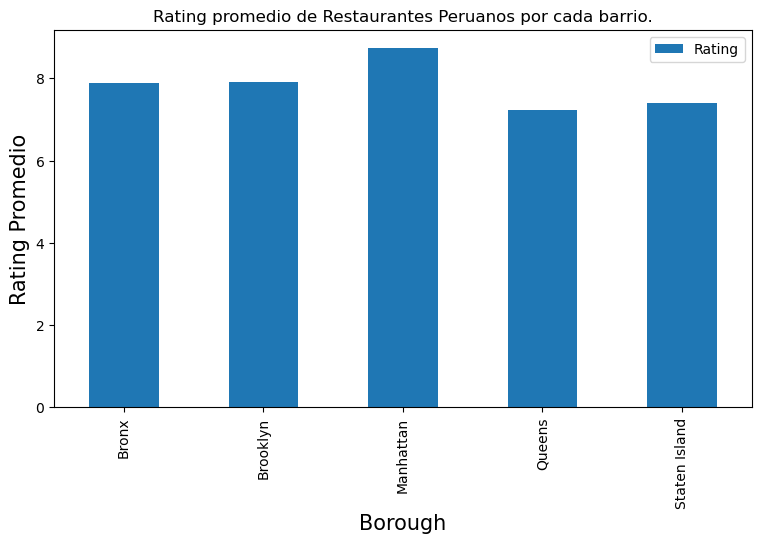

In [64]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Rating promedio de Restaurantes Peruanos por cada barrio.')
#On x-axis
plt.xlabel('Barrio', fontsize = 15)
#On y-axis
plt.ylabel('Rating Promedio', fontsize=15)
#giving a bar plot
peruvian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

##### Podemos deducir que el barrio de 'Manhattan' es el que tiene mejor promedio de Rating en cuanto a los restaurantes peruanos.

Para graficar en el mapa, consideraremos los vecindarios que tienen un rating promedio mayor a 8.5

In [65]:
ny_nb=ny_nb_rating[ny_nb_rating['Average Rating']>=8.5]
ny_nb

,Neighborhood,Average Rating
4,Clinton,8.85
6,Corona,8.50
7,Douglaston,8.60
8,Downtown,8.50
10,Elmhurst,8.50
15,Greenwich Village,9.10
19,Hudson Yards,8.85
22,Little Neck,8.60
23,Manhattan Valley,8.60
31,Port Morris,8.60


Unimos este dataset al original para obtener las latitudes y longitudes:

In [66]:
ny_nb=pd.merge(ny_nb,df, on='Neighborhood')
ny_nb=ny_nb[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_nb

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Clinton,40.759101,-73.996119,8.85
1,Queens,Corona,40.742382,-73.856825,8.50
2,Queens,Douglaston,40.766846,-73.742498,8.60
3,Brooklyn,Downtown,40.690844,-73.983463,8.50
4,Queens,Elmhurst,40.744049,-73.881656,8.50
5,Manhattan,Greenwich Village,40.726933,-73.999914,9.10
6,Manhattan,Hudson Yards,40.756658,-74.000111,8.85
7,Queens,Little Neck,40.770826,-73.738898,8.60
8,Manhattan,Manhattan Valley,40.797307,-73.964286,8.60
9,Bronx,Port Morris,40.801664,-73.913221,8.60


In [67]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [75]:
foliumap = folium.map.FeatureGroup()

for lat, lng, in ny_nb[['Latitude','Longitude']].values:
    foliumap.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
ny_nb['Label']=ny_nb['Neighborhood']+', '+ny_nb['Borough']+'('+ny_nb['Average Rating'].map(str)+')'

# añadir un pop-up de texto dentro de cada circulo
for lat, lng, label in ny_nb[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# añadir al mapa y mostrar
ny_map.add_child(foliumap)

### Conclusión:

Luego de realizar este análisis podemos responder las preguntas planteadas:

<b> 1. ¿Cuales son los mejores lugares en Nueva York para la cocina Peruana? </b> \
Greenwich Village (Manhattan), West Village (Manhattan), Clinton (Manhattan) y Hudson Yards (Manhattan) son los mejores lugares para la cocina peruana.

<b> 2. ¿Qué áreas tienen el potencial del mercado de restaurantes peruanos? </b> \
Manhattan tiene un potencial alto para el mercado de cocina peruana.

<b> 3. ¿Cuál es el mejor lugar para invertir en aperturar un restaurante de comida Peruana? </b> \
La mejor opción para invertir en un restaurante de comida peruana es en <b>Manhattan</b>, especialmente en <b>Greenwich Village </b> y <b>West Village</b>.